## Plotting 2d ASPECT rift models using Pyvista

In [1]:
#!conda install pyvistaqt -y
#!conda install -c conda-forge cmocean -y


In [2]:
import pyvista as pv
import numpy as np
import glob
import natsort
import pyvistaqt
import matplotlib.pyplot as plt
import cmocean

In [3]:
#path to APSECT output folders
fbase = '/media/dan/seagate_exansion/gadi/2dmodels/rifting/'

#name of the aspect output folder
modname = 'output_kerg_F3/'
#get a list of all ptvu files (1 for each saved timestep)
pvtu_files = natsort.natsorted(glob.glob(fbase + modname + 'solution/*.pvtu')) 

In [4]:
#choose index of file
i = -1
vtk_data = pv.read(pvtu_files[i])


#scale sets the vertical exgeration by actually scaling the data point
#there is probably a better way to do this!
scale = 2
vtk_data.points[:, 1] *= scale

In [5]:
#set the camera position

cam_pos =[(95514.35309167023, 161975.97748789148, -211735.22931195388),
 (95514.35309167023, 161975.97748789148, 0.0),
 (0.0, 1.0, 0.0)]

## Setup thresholds and contours, etc

In [6]:
stripes_thresh  = vtk_data.threshold([0.75, 1.25], 
                              scalars='stripes', 
                              all_scalars=False)



stripes_sed1  = vtk_data.threshold([0.5, 1.9], 
                              scalars='sediment_1', 
                              all_scalars=False)

stripes_sed2  = vtk_data.threshold([0.5, 1.9], 
                              scalars='sediment_2', 
                              all_scalars=False)



vtk_data2 = vtk_data.copy()
vtk_data2.points[:,2] -= 2e3
temp_thresh = vtk_data2.threshold([0, 873], 
                              scalars='T')

2022-06-17 10:13:50.227 (   2.597s) [         BE99740]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
2022-06-17 10:13:50.303 (   2.673s) [         BE99740]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
2022-06-17 10:13:50.411 (   2.780s) [         BE99740]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.
2022-06-17 10:13:50.560 (   2.930s) [         BE99740]       vtkThreshold.cxx:96    WARN| vtkThreshold::ThresholdBetween was deprecated for VTK 9.1 and will be removed in a future version.


In [7]:
contours = vtk_data.contour(isosurfaces=[673, 873, 1073], 
                             scalars='T')


sed_contours = vtk_data.contour(isosurfaces=[0.5], 
                             scalars='sediment_1')

In [11]:
#set up a box which will represent the water level when plotted behind the rift model

sea_level = 1000

plane = pv.Plane(center=(100e3, 50e3, 1e3),
    direction=(0, 0, 1),
    i_size=200e3,
    j_size=102e3)


plane.points[:, 1] *= scale

In [9]:
#customise color bar

sargs = dict(
    title_font_size=32,
    label_font_size=20,
    height=0.25,
    shadow=True,
    n_labels=5,
    italic=True,
    #fmt="%.1f",
    font_family="arial",
    title = "differential stress (Pa)"
)

## Plot

In [13]:
p = pv.Plotter( window_size = (1000, 600), border=True, border_color='black', border_width=2.0)


p.add_mesh(stripes_thresh, color="white", opacity = 0.9)


p.add_mesh(temp_thresh, scalars = 'plastic_strain',  cmap ='Greys', clim = [0.3, 1],
           opacity = 'sigmoid_r',  use_transparency=True, show_scalar_bar=False)

p.add_mesh(vtk_data, scalars = 've_stress_xx', clim = [-100e6, 100e6],
           cmap='coolwarm_r', opacity = 1.0, scalar_bar_args=sargs)


p.add_mesh(stripes_sed1, color='green', opacity = 1.0)
p.add_mesh(stripes_sed2, color='orange', opacity = 1.0)



p.add_mesh(contours, color="black", line_width=1.5)
p.add_mesh(sed_contours, color="black", line_width=1.)


p.add_mesh(plane, color="lightblue", opacity = 0.75)


p.camera_position = cam_pos


#save the figure
#p.screenshot('./figs/stripes_sr.png')



p.render()
p.show()




ViewInteractiveWidget(height=600, layout=Layout(height='auto', width='100%'), width=1000)

## Sample over line

Set up vertical line ant look at the depth variation of the stress

In [94]:
#undo the scaling we did for the plotting
vtk_data.points[:, 1] *= 1/scale

In [49]:
xpos = 175e3
surface_height = 101.e3

pa = (xpos, surface_height, 0)
pb = (xpos, 50e3, 0)

In [50]:
friction_angle =   20.
cohesion      = 20.e6

cohesion_weak = 0.5
friction_weak = 0.25

crust_thick = 20e3
crust_rho = 2900
mantle_rho = 3300

In [51]:
#get the components of the full stress tensor, 
#for details, see Sandiford et al, 
#Kinematics of footwall exhumation at oceanic detachment faults: solid‐block rotation and apparent unbending


dte_years = 10e3
y2s = 3.154e7
shear_mod = 1e10


vtk_data.point_arrays['full_stress_xx'] = \
vtk_data.point_arrays['viscosity']*(2*vtk_data.point_arrays['strain_rate_tensor_xx']*np.sqrt(1) + \
                                    vtk_data.point_arrays['ve_stress_xx']/(dte_years*y2s*shear_mod))

vtk_data.point_arrays['full_stress_yy'] = \
vtk_data.point_arrays['viscosity']*(2*vtk_data.point_arrays['strain_rate_tensor_yy']*np.sqrt(1) + \
                                    vtk_data.point_arrays['ve_stress_yy']/(dte_years*y2s*shear_mod))


vtk_data.point_arrays['full_stress_xy'] = \
vtk_data.point_arrays['viscosity']*(2*vtk_data.point_arrays['strain_rate_tensor_xy']*np.sqrt(1) + \
                                    vtk_data.point_arrays['ve_stress_xy']/(dte_years*y2s*shear_mod))

/home/dan/anaconda3/envs/t21-pyvista/lib/python3.7/site-packages/pyvista/core/dataset.py:1404: PyvistaDeprecationWarning: Use of `point_arrays` is deprecated. Use `point_data` instead.
  PyvistaDeprecationWarning


In [52]:

#sample the data and extract values
sampled = vtk_data.sample_over_line(pointa = pa, 
                                            pointb=pb,
                                            resolution=int(2e3)
                                 )



depths = sampled['Distance']
stress_xx = sampled.get_array('full_stress_xx')
stress_yy = sampled.get_array('full_stress_yy')
pressure = sampled.get_array('p')


lithpress = np.zeros_like(depths)
mask = depths < crust_thick
lithpress[mask] = depths[mask]*crust_rho*9.8

lithpress[np.invert(mask)] = crust_thick*crust_rho*9.8 + \
(depths[np.invert(mask)] - crust_thick)*mantle_rho*9.8

## What does the folllowing plot show?

In the rift flank, the vertical stress (blue) is equal to the overburden pressure 

the difference between the vertival and Horizontal stress is the diffeential stress, which depends on the yield strength 

beneath about 25 km, this lithospheric model has no strength

there is a strength jump at the moho - the lithopsheric mantle contribues some strength in this model

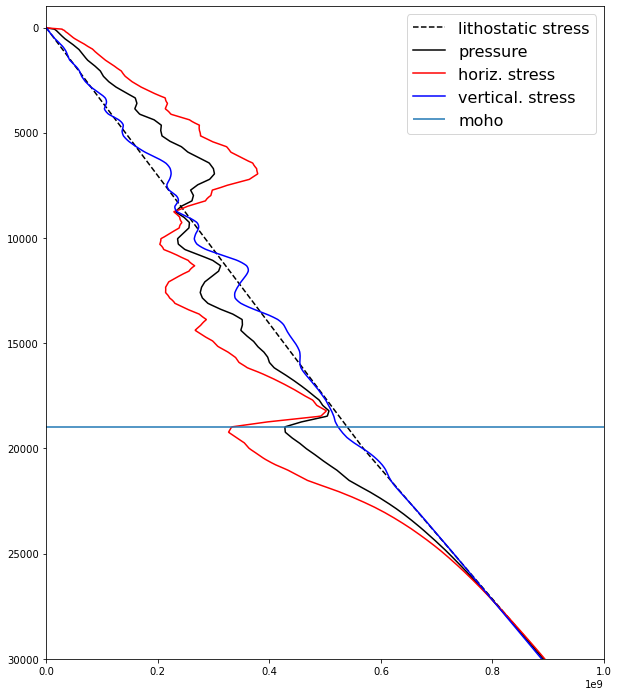

In [53]:
fig, ax = plt.subplots(figsize=(10, 12))


ax.plot(lithpress, depths, c = 'k', ls = '--',  label = 'lithostatic stress')
ax.plot(pressure,  depths, c = 'k', ls = '-', label = 'pressure')

#teh negative 1 signs make the stress and pressure sign conventions compatiable
ax.plot(pressure + -1*stress_xx,  depths, c = 'r',  label = 'horiz. stress')
ax.plot(pressure + -1*stress_yy,  depths, c = 'b', label = 'vertical. stress')

ax.set_ylim(30e3, -1e3)
ax.set_xlim(0, 1e9)

ax.hlines(20e3 - (surface_height - 100e3) , 0, 1e9, label = 'moho')

ax.legend(loc = 1, fontsize = 16)


In [55]:
#look at the expected differential stress from the Mohr Coulomb relatinship


fc0 = np.tan(np.deg2rad(friction_angle))
fc1 = np.tan(np.deg2rad(friction_weak*friction_angle))


mc_comp0 = -2*( fc0*lithpress)/(np.sqrt(fc0**2 + 1.) - fc0) - cohesion
mc_comp1 = -2*(fc1*lithpress)/(np.sqrt(fc1**2 + 1.) - fc1) - cohesion*cohesion_weak



mc_ext0 = 2*( fc0*lithpress)/(np.sqrt(fc0**2 + 1.) + fc0) + cohesion
mc_ext1 = 2*( fc1*lithpress)/(np.sqrt(fc1**2 + 1.) + fc1) + cohesion*cohesion_weak



In [56]:
fc0

0.36397023426620234

In [57]:
2*cohesion/((np.sqrt(fc0**2 + 1.) - fc0))

57125920.26968458

## What does the folllowing plot show?


The filled areas show teh brittle strength in compression (negative values) and extenesion (positive)
The lower limit correspond to the effect of strain weakening

The horizontal stress is effectively teh differential stress in the model (as we know one of the princiapl stresses is close to vertical and ste by the lithostatic stress).

The stress pattern is a superposition of the flexural stress due to rift flank uplift and the net axial stress which is driving the extension

At this point in the model the rift flank neutral plane sits at about 10 km. Brittle fauliure dominates inthe crust and upper most part of the lithopsheric matle also intersects the brittle yield envelope. 



In [80]:
neutral_plane_est = 8.6e3

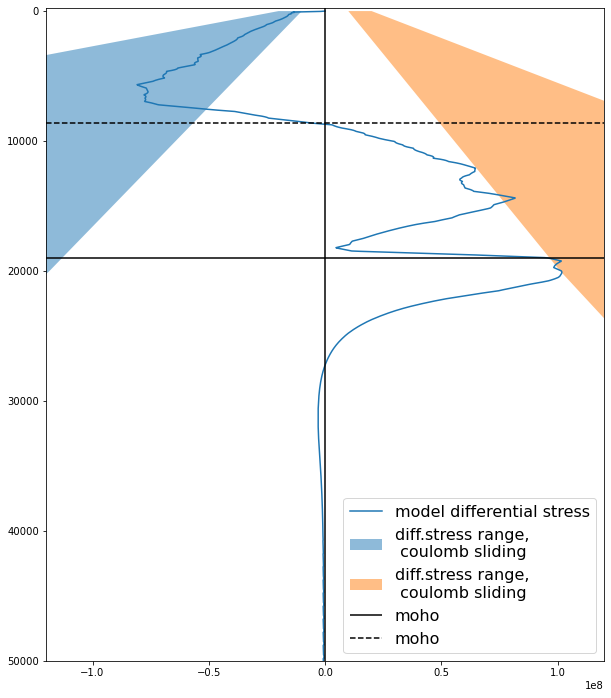

In [82]:
fig, ax = plt.subplots(figsize=(10, 12))


ax.plot(stress_xx, depths, label = 'model differential stress')
#ax.plot(mc_comp0, depth, c = 'r')
#ax.plot(mc_comp1, depth, c = 'b')

ax.fill_betweenx(depths, mc_comp0, mc_comp1, alpha = 0.5, label='diff.stress range, \n coulomb sliding')
ax.fill_betweenx(depths, mc_ext0, mc_ext1, alpha = 0.5, label='diff.stress range, \n coulomb sliding')


#ax.fill_between()

ax.set_ylim(50e3, -0.2e3)

ax.set_xlim(-120e6, 120e6)

ax.vlines(0,100e3, -1e3, colors = 'k' )

ax.hlines(20e3 - (surface_height - 100e3), -120e6, 120e6, label = 'moho', colors = 'k')
ax.hlines(neutral_plane_est, -120e6, 120e6, label = 'moho', colors = 'k', linestyles = '--')


#ax.vlines(-20e6, 100e3, -1e3 )
#ax.vlines(-40e6, 100e3, -1e3 )

ax.legend(loc = 4, fontsize = 16)


## What is the net extensional stress in rift flank?

In [64]:
from scipy.integrate import trapezoid

In [72]:
net_axial_stress = trapezoid(stress_xx, depths)

print(net_axial_stress*1e-12)

#recall typical ridge push magnitudes are ~ (2-3)x1e12


0.35890551613084715


## other stuff

In [ ]:
#th
#p = pyvistaqt.BackgroundPlotter()
#p.add_mesh(vtk_data, scalars = 'stripes', cmap='coolwarm')
#p.show()